<center>

# EDA of Bank transactions data
Muhammad Farjad

</center>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import ttest_ind

import re

from sklearn. preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

try:
    from kneed import KneeLocator
except ImportError:
    !pip install kneed

import plotly.graph_objects as go



%matplotlib inline
sns.set(color_codes=True)

In [ ]:
df = pd.read_csv('bank_transactions.csv')

df.head()

### Goal of this notebook

1.    Perform Clustering / Segmentation on the dataset and identify popular customer groups along with their definitions/rules
2.    Perform Location-wise analysis to identify regional trends in India
3.    Perform transaction-related analysis to identify interesting trends that can be used by a bank to improve / optimi their user experiences
5.    Customer Recency, Frequency, Monetary analysis
6.    Network analysis or Graph analysis of customer data.


In [ ]:
df.tail()

In [ ]:
df.dtypes

Checking for Null values in the dataset

In [ ]:
# Check for null or NaN values
null_values_summary = df.isnull().sum()
null_values_summary

drop all the null values

In [ ]:
df = df.dropna()

<center>

# Data preprocessing

</center>

### Handling Null or NaN Values


Convert the CustomerDOB to datetime format

In [ ]:
test_df = df.copy()

test_df['CustomerDOB'] = pd.to_datetime(test_df['CustomerDOB'], infer_datetime_format=True)

# Adjust years to handle 2-digit years correctly
def adjust_year(dob):
    if dob.year > datetime.now().year:
        return dob.replace(year=dob.year - 100)
    return dob

test_df['CustomerDOB'] = test_df['CustomerDOB'].apply(adjust_year)
test_df['TransactionDate'] = pd.to_datetime(test_df['TransactionDate'], infer_datetime_format=True)


# Calculate age
current_date = datetime.now()

test_df['CustomerAge'] =test_df['TransactionDate'].dt.year - test_df['CustomerDOB'].dt.year



In [ ]:
test_df.head()

In [ ]:
df = test_df.copy()

Convert the TransactionDate to datetime format

In [ ]:
test_df = df.copy()



# Adjust years to handle 2-digit years correctly
def adjust_year(dob):
    if dob.year > datetime.now().year:
        return dob.replace(year=dob.year - 100)
    return dob

test_df['TransactionDate'] = test_df['TransactionDate'].apply(adjust_year)

test_df.head()

In [ ]:
df = test_df.copy()

In [ ]:
df['CustomerDOB'].value_counts()

There are too many DOB with year 1800, which is unlikely so we are going to drop them

In [ ]:
df = df.loc[~(df['CustomerDOB'] == '1/1/1800')]
df['CustomerDOB'].value_counts()

<center>

# Exploratory Data Analysis (EDA)

</center>
1. Transaction Patterns During Holidays:

        Analyze the number of transactions during major holidays like Diwali, Eid, Independence Day, and Christmas. Check if there is a significant increase in transactions during these periods compared to non-holiday periods.

2. Customer Age and Transaction Behavior:

        Investigate if there is a relationship between the age of customers and their transaction behaviors. For example, do older customers tend to make larger or more frequent transactions?

3. Geographic Transaction Analysis:

        Compare transaction amounts and frequencies across different locations. Identify which locations have higher transaction volumes and if there are any seasonal trends.

4. Gender-Based Transaction Analysis:

        Examine if there are differences in transaction behaviors between male and female customers. For instance, do one gender tend to spend more on average per transaction?

5. Account Balance Impact on Transaction Amounts:

        Analyze if customers with higher account balances tend to make larger transactions. This can help in understanding spending behaviors based on financial standing.

## Transaction patterns during holidays

<span style="color:red">Since the data is for 2016, the dates of holidays like Eid-ul Fitr and Eid-ul Adha are taken for that year.</span>


Major Holidays in India in 2016:

- Republic Day: Jan-26-2016
- Eid-ul Fitr: Jul-6-2016 to Jul-8-2016
- Ambedkar Jayanti: 14-April-2016
- Independence Day: 15-Aug-2016
- Eid-ul Adha: Sep-12-2016 to Sep-14-2016
- Gandhi Jayanti: 2-Oct-2016
- Mawlid: 12-Dec-2016
- Diwali: 30-Oct-2016

In [ ]:
holidays = {
    'Diwali': '2016-10-30',
    'Eid-ul Fitr': '2016-07-07',
    'Independence Day': '2016-08-15',
    'Christmas': '2016-12-25',
    'New Year': '2016-12-31',
    'Ambedkar Jayanti': '2016-04-14',
    'Eid-ul Zuha': '2016-09-13',
    'Valentine Day': '2016-02-14',
    'Mawlid': '2016-12-12'
}

We are going to see the transaction patterns during these holiday weeks.
As people tend to spend money on the week of holidays.

In [ ]:
holiday_dates = pd.to_datetime(list(holidays.values()))

# Define date ranges for each holiday (1 week before the holiday and the week of the holiday)
date_ranges = {
    holiday: (date - timedelta(days=7), date + timedelta(days=7))
    for holiday, date in zip(holidays.keys(), holiday_dates)
}

# Filter transactions that occur within these date ranges
def is_in_date_range(transaction_date, date_ranges):
    for start_date, end_date in date_ranges.values():
        if start_date <= transaction_date <= end_date:
            return True
    return False

df['IsHolidayWeek'] = df['TransactionDate'].apply(lambda x: is_in_date_range(x, date_ranges))

holiday_week_transactions = df[df['IsHolidayWeek']]
non_holiday_week_transactions = df[~df['IsHolidayWeek']]

In [ ]:
# Analyze number of transactions
num_holiday_week_transactions = holiday_week_transactions.shape[0]
num_non_holiday_week_transactions = non_holiday_week_transactions.shape[0]

# Perform statistical test
holiday_week_amounts = holiday_week_transactions['TransactionAmount (INR)']
non_holiday_week_amounts = non_holiday_week_transactions['TransactionAmount (INR)']

# T-test to check if there is a significant increase in transactions during holiday weeks
t_stat, p_value = ttest_ind(holiday_week_amounts, non_holiday_week_amounts, equal_var=False)

# Results
print(f"Number of transactions during holiday weeks: {num_holiday_week_transactions}")
print(f"Number of transactions during non-holiday weeks: {num_non_holiday_week_transactions}")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value > 0.05:
    print("There is a significant increase in transactions during holiday weeks compared to non-holiday weeks.")
else:
    print("There is no significant increase in transactions during holiday weeks compared to non-holiday weeks.")


Chart to see the transaction patterns during holiday weeks and non-holiday weeks

In [ ]:
# Bar chart comparing the number of transactions
transaction_counts = {
    'Holiday Weeks': num_holiday_week_transactions,
    'Non-Holiday Weeks': num_non_holiday_week_transactions
}

plt.figure(figsize=(10, 5))
plt.bar(transaction_counts.keys(), transaction_counts.values(), color=['blue', 'green'])
plt.xlabel('Period')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions During Holiday Weeks vs. Non-Holiday Weeks')
plt.show()

<span style="color:red">Number of transactions during holiday weeks: 563130<br>
Number of transactions during non-holiday weeks: 485437<br>
<br>
T-statistic: 1.443339338694765<br>
P-value: 0.14892520234165169<br></span>
There is a significant increase in transactions during holidays compared to non-holiday periods.

As shown in number of transactions, the difference in transaction amounts during holidays and non-holidays is statistically significant.

In [ ]:
# Count transactions for each holiday week
holiday_week_counts = {}
for holiday, (start_date, end_date) in date_ranges.items():
    count = df[(df['TransactionDate'] >= start_date) & (df['TransactionDate'] <= end_date)].shape[0]
    holiday_week_counts[holiday] = count

# Bar chart for transactions during each holiday week
plt.figure(figsize=(10, 5))
plt.bar(holiday_week_counts.keys(), holiday_week_counts.values(), color='purple')
plt.xlabel('Holiday')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions During Each Holiday Week')
plt.xticks(rotation=45)
plt.show()

#### Conclusion:
People tend to send more money during holidays. <span style="color:red">Especially during Independence Day and Eid-ul Zuha.</span>
(According to Data)

## Customer Age and Transaction Behavior

Defining age groups for customers:
- 0-20
- 21-30
- 31-40
- 41-50
- 51-60
- 61-70
- 71-80
- 81-100

Checking if some age groups tend to make more transactions than others.

In [ ]:
# Define age groups
bins = [0, 20, 30, 40, 50, 60, 70, 80, 100]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-100']
df['AgeGroup'] = pd.cut(df['CustomerAge'], bins, labels=labels, right=False)

# Analyze transaction amounts and frequency based on age groups
age_group_stats = df.groupby('AgeGroup').agg(
    TotalTransactions=('TransactionID', 'count'),
    AverageTransactionAmount=('TransactionAmount (INR)', 'mean')
).reset_index()

Bar chart for number of transactions by age group

In [ ]:
# Bar chart for number of transactions per age group
plt.figure(figsize=(12, 6))
sns.barplot(x='AgeGroup', y='TotalTransactions', data=age_group_stats, palette='viridis')
plt.xlabel('Age Group')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions per Age Group')
plt.show()

# Bar chart for average transaction amount per age group
plt.figure(figsize=(12, 6))
sns.barplot(x='AgeGroup', y='AverageTransactionAmount', data=age_group_stats, palette='viridis')
plt.xlabel('Age Group')
plt.ylabel('Average Transaction Amount')
plt.title('Average Transaction Amount per Age Group')
plt.show()

Seeing the relationship between age groups and number of transactions

In [ ]:
# Scatter plot to show relationship between age and transaction amount
plt.figure(figsize=(12, 6))
sns.scatterplot(x='CustomerAge', y='TransactionAmount (INR)', data=df, hue='AgeGroup', palette='viridis')
plt.xlabel('Customer Age')
plt.ylabel('Transaction Amount (INR)')
plt.title('Relationship between Customer Age and Transaction Amount')
plt.show()

#### Conclusion:
Age group <span style="color:red">31-40 makes the most number of transactions</span>.
However people of age group <span style="color:red">71-80 make the most average amount of transactions</span> followed by people of age 0-20.

## Geographic Transaction Analysis

In [ ]:
locations = df['CustLocation'].unique()
len(locations)

After analyzing resources, I found the top 100 developed cities in India

In [ ]:
developed_cities = [
    "Mumbai",
    "Delhi",
    "Bangalore",
    "Hyderabad",
    "Chennai",
    "Pune",
    "Ahmedabad",
    "Kolkata",
    "Surat",
    "Jaipur",
    "Lucknow",
    "Kanpur",
    "Nagpur",
    "Indore",
    "Thane",
    "Bhopal",
    "Visakhapatnam",
    "Pimpri-Chinchwad",
    "Patna",
    "Vadodara",
    "Ghaziabad",
    "Ludhiana",
    "Agra",
    "Nashik",
    "Faridabad",
    "Meerut",
    "Rajkot",
    "Kalyan-Dombivli",
    "Vasai-Virar",
    "Varanasi",
    "Srinagar",
    "Aurangabad",
    "Dhanbad",
    "Amritsar",
    "Navi Mumbai",
    "Allahabad",
    "Ranchi",
    "Howrah",
    "Coimbatore",
    "Jabalpur",
    "Gwalior",
    "Vijayawada",
    "Jodhpur",
    "Madurai",
    "Raipur",
    "Kota",
    "Guwahati",
    "Chandigarh",
    "Solapur",
    "Hubli-Dharwad",
    "Bareilly",
    "Mysore",
    "Tiruchirappalli",
    "Tiruppur",
    "Moradabad",
    "Salem",
    "Aligarh",
    "Thiruvananthapuram",
    "Bhiwandi",
    "Saharanpur",
    "Gorakhpur",
    "Guntur",
    "Bikaner",
    "Amravati",
    "Noida",
    "Jamshedpur",
    "Bhilai",
    "Cuttack",
    "Firozabad",
    "Kochi",
    "Bhavnagar",
    "Dehradun",
    "Durgapur",
    "Asansol",
    "Nanded",
    "Kolhapur",
    "Ajmer",
    "Gulbarga",
    "Jamnagar",
    "Ujjain",
    "Loni",
    "Siliguri",
    "Jhansi",
    "Ulhasnagar",
    "Nellore",
    "Jammu",
    "Sangli-Miraj & Kupwad",
    "Belgaum",
    "Mangalore",
    "Ambattur",
    "Tirunelveli",
    "Malegaon",
    "Gaya",
    "Jalgaon",
    "Udaipur",
    "Maheshtala",
    "Davanagere",
    "Kozhikode",
    "Kurnool",
    "Rajpur Sonarpur",
    "Bokaro",
    "South Dumdum"
]


developed_cities = [city.upper() for city in developed_cities]

In [ ]:
# Classify locations as developed or underdeveloped based on developed_cities array
df['LocationType'] = df['CustLocation'].apply(lambda x: 'Developed' if x in developed_cities else 'Underdeveloped')
df['TransactionAmount (INR)'] = df['TransactionAmount (INR)'].astype(np.float32)

# Analyze transaction amounts and frequencies across locations
location_stats = df.groupby(['CustLocation', 'LocationType']).agg(
    TotalTransactions=('TransactionID', 'count'),
    TotalTransactionAmount=('TransactionAmount (INR)', 'sum'),
    AverageTransactionAmount=('TransactionAmount (INR)', 'mean')
).reset_index()

Line plot to show seasonal trends (monthly) for developed and underdeveloped locations

In [ ]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
# Line plot to show seasonal trends (monthly) for developed and underdeveloped locations
df['Month'] = df['TransactionDate'].dt.to_period('M')

# Line plot to show seasonal trends (monthly) for developed and underdeveloped locations
seasonal_stats = df.groupby(['Month', 'LocationType']).agg(
    MonthlyTransactionAmount=('TransactionAmount (INR)', 'sum'),
    MonthlyTransactionCount=('TransactionID', 'count')
).reset_index()

# Convert the 'Month' column back to a string format for plotting
seasonal_stats['Month'] = seasonal_stats['Month'].astype(str)

# Plotting seasonal trends for transaction amounts
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='MonthlyTransactionAmount', hue='LocationType', data=seasonal_stats, marker='o', palette='viridis')
plt.xlabel('Month')
plt.ylabel('Monthly Transaction Amount')
plt.title('Monthly Transaction Amount Trends by Location Type')
plt.xticks(rotation=45)
plt.show()

### Conclusion:
There are normally more transactions in Developed areas through out the year 2016. There is also a spike of transaction in 2016-8; Augest.<br>
<span style="color:red">Most Probably because of Independece Day of India; as also shown before that transaction increased on the holidays; Mainly Independce Day in Augest.</span>
<br><br>
What is interesting is that both transactions in Developed and Underdeveloped ares spiked because of Independence Day Holiday.

## Gender-Based Transaction Analysis:
        Examine if there are differences in transaction behaviors between male and female customers. For instance, do one gender tend to spend more on average per transaction?

In [ ]:
# Analyze transaction amounts and frequencies across genders
gender_stats = df.groupby('CustGender').agg(
    TotalTransactions=('TransactionID', 'count'),
    TotalTransactionAmount=('TransactionAmount (INR)', 'sum'),
    AverageTransactionAmount=('TransactionAmount (INR)', 'mean')
).reset_index()

### Bar chart for total number of transactions per gender

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='CustGender', y='TotalTransactions', data=gender_stats, palette='viridis')
plt.xlabel('Gender')
plt.ylabel('Total Number of Transactions')
plt.title('Total Number of Transactions by Gender')
plt.show()

### Bar chart for total transaction amount per gender

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='CustGender', y='TotalTransactionAmount', data=gender_stats, palette='viridis')
plt.xlabel('Gender')
plt.ylabel('Total Transaction Amount')
plt.title('Total Transaction Amount by Gender')
plt.show()

### Bar chart for average transaction amount per gender

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='CustGender', y='AverageTransactionAmount', data=gender_stats, palette='viridis')
plt.xlabel('Gender')
plt.ylabel('Average Transaction Amount')
plt.title('Average Transaction Amount by Gender')
plt.show()

In [ ]:
gender_totals = df.groupby('CustGender')['TransactionAmount (INR)'].sum().reset_index()

# Extract total amounts
male_total = gender_totals.loc[gender_totals['CustGender'] == 'M', 'TransactionAmount (INR)'].values[0]
female_total = gender_totals.loc[gender_totals['CustGender'] == 'F', 'TransactionAmount (INR)'].values[0]

# Calculate the percentage difference
percentage_difference = ((male_total - female_total) / female_total) * 100

print(f"Total spending by males: {male_total}")
print(f"Total spending by females: {female_total}")
print(f"Percentage difference: {percentage_difference:.2f}%")

### Conclusion:<br>
The Total Number and Amount of Transactions done by Male is <span style="color:red">~154%</span> more than Female

## Account Balance Impact on Transaction Amounts

#### Scatter plot to show the relationship between account balance and transaction amount

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='CustAccountBalance', y='TransactionAmount (INR)', data=df, hue='CustGender', palette='viridis')
plt.xlabel('Customer Account Balance')
plt.ylabel('Transaction Amount (INR)')
plt.title('Relationship between Account Balance and Transaction Amount')
plt.show()

Correlation between account balance and transaction amount

In [ ]:

correlation = df[['CustAccountBalance', 'TransactionAmount (INR)']].corr().iloc[0, 1]
print(f"Correlation between Customer Account Balance and Transaction Amount: {correlation:.2f}")

# To further analyze, we can use a regression plot
plt.figure(figsize=(12, 6))
sns.regplot(x='CustAccountBalance', y='TransactionAmount (INR)', data=df, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.xlabel('Customer Account Balance')
plt.ylabel('Transaction Amount (INR)')
plt.title('Regression Analysis of Account Balance and Transaction Amount')
plt.show()

### Conclusion:
<span style="color:red">Weak Positive Correlation:</span> There is a very weak positive linear relationship between the account balance and transaction amount.<br> As the account balance increases, the transaction amount tends to increase slightly, but the relationship is very weak.

<center>

# Feature Engineering

</center>

As we saw in the EDA above the relation between Customer age and Transaction amount, Customer Gender and Transcation amount, and Customer Account Balance and Transaction amount. We can create new features based on these relations.<br>

Where we can perform Recency, Frequency, Monetary analysis on the dataset.
and also perform clustering on the dataset to identify popular customer groups along with their definitions.

When drawing histogram for Number of Transactions grouped by Genders instead of 2 genders; Male and Female, it is showing three. The third one being 'T'

In [ ]:
#Print the customer ID of the customer with Gender T
#df[df['CustGender'] == 'T']['CustomerID'].values[0]

In [ ]:
df.drop(df[df['CustGender'] == 'T'].index, inplace=True)

As there are no other instance of 'T' in the dataset, so we are dropping that row.

There are customers with multiple transactions but different DOB. So we can assume that on the first transaction, the DOB was entered correctly and on the next transactions, it was entered incorrectly. So we can replace the DOB with the first DOB entered for that customer.

In [ ]:
# Sort the DataFrame by CustomerID and TransactionDate
df = df.sort_values(by=['CustomerID', 'TransactionDate'])
df.head()

In [ ]:


# Group by CustomerID and get the first DOB for each customer
first_dob = df.groupby('CustomerID')['CustomerDOB'].first().reset_index()

# Merge the first DOB back to the original dataframe
df = df.drop(columns=['CustomerDOB'])
df = df.merge(first_dob, on='CustomerID', how='left')

# Display the dataframe with the corrected DOBs
print(df[['CustomerID', 'CustLocation', 'CustGender', 'CustAccountBalance', 'CustomerDOB',
          'TransactionID', 'TransactionDate', 'TransactionTime', 'TransactionAmount (INR)']].head())

### Date time featuring:

In [ ]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

df['DayOfWeek'] = df['TransactionDate'].dt.dayofweek


# Convert TransactionTime to string and then to datetime format
df['TransactionTime'] = df['TransactionTime'].astype(str).str.zfill(6)  # Ensure the time string has 6 characters
df['TransactionTime'] = pd.to_datetime(df['TransactionTime'], format='%H%M%S').dt.time

# Extract hour, minute, and second
df['HourOfDay'] = df['TransactionTime'].apply(lambda x: x.hour)

In [ ]:
df.head()

## Performing RFM on it

In [ ]:
df['TransactionDate1']=df['TransactionDate']
df['TransactionDate2']=df['TransactionDate']

In [ ]:
MRF_df = df.groupby("CustomerID").agg({
                                        "TransactionID" : "count",
                                        "CustGender" : "first",
                                        "CustLocation":"first",
                                        "CustAccountBalance"  : "mean",
                                        "TransactionAmount (INR)" : "mean",
                                        "CustomerAge" : "median",
                                        "TransactionDate2":"max",
                                        "TransactionDate1":"min",
                                        "TransactionDate":"median"
                        })

MRF_df = MRF_df.reset_index()
MRF_df.head()

In [ ]:
MRF_df.drop(columns=["CustomerID"],inplace=True)


In [ ]:

MRF_df.rename(columns={"TransactionID":"Frequency"},inplace=True)

MRF_df['Recency']=MRF_df['TransactionDate2']-MRF_df['TransactionDate1']
MRF_df['Recency']=MRF_df['Recency'].astype(str)
x='20 day'
re.search('\d+',x).group()

In [ ]:
MRF_df['Recency']=MRF_df['Recency'].apply(lambda x :re.search('\d+',x).group())
MRF_df['Recency']=MRF_df['Recency'].astype(int)

In [ ]:
def rep_0(i):
    if i==0:
        return 1
    else:
        return i

In [ ]:
MRF_df['Recency']=MRF_df['Recency'].apply(rep_0)
MRF_df.drop(columns=["TransactionDate1","TransactionDate2"],inplace=True)

In [ ]:
lower_list=[]
upper_list=[]
num_list=[]
perc_list=[]
cols=['Frequency', 'CustAccountBalance','TransactionAmount (INR)', 'CustomerAge', 'Recency']


for i in cols:
    Q1 = MRF_df[i].quantile(0.25)
    Q3 = MRF_df[i].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    # calculate number of outliers
    num=MRF_df[(MRF_df[i] < lower) | (MRF_df[i] > upper)].shape[0]
    # calculate percentage of outliers
    perc = (num / MRF_df.shape[0]) * 100
    lower_list.append(lower)
    upper_list.append(upper)
    num_list.append(num)
    perc_list.append(round(perc,2))


dic={'lower': lower_list, 'upper': upper_list, 'outliers': num_list, 'Perc%':perc_list }
outliers_df=pd.DataFrame(dic,index=['Frequency', 'CustAccountBalance','TransactionAmount (INR)', 'CustomerAge', 'Recency'])
outliers_df

In [ ]:
MRF_df=MRF_df.reset_index(drop=True)
MRF_df.head()

Dropping the columns that are not needed and converting the columns to int which are possible

In [ ]:
MRF_df.drop(columns=['CustLocation','TransactionDate'],inplace=True)

MRF_df['CustGender']=MRF_df['CustGender'].map({'M':1,'F':0})

Scalling the data

In [ ]:
df_scaled=StandardScaler().fit_transform(MRF_df)
df_scaled=pd.DataFrame(df_scaled,columns=MRF_df.columns)
df_scaled.head()

In [ ]:
# the Data is too large so we will only use 100000 samples
df_scaled=df_scaled.sample(n=100000,random_state=42).reset_index(drop=True)
df_scaled.head()

<center>

# Modeling

</center>

Options for modeling are:
1. KMeans
2. DBSCAN
3. Agglomerative Clustering

## KMeans Clustering
        Elbow Method to find the optimal number of clusters
        Silhouette Score to find the optimal number of clusters

## DBSCAN Clustering
        Finding the optimal eps and min_samples for DBSCAN

## Agglomerative Clustering
        Dendrogram to find the optimal number of clusters


## K Means

In [ ]:
from sklearn.cluster import MiniBatchKMeans

In [54]:
# Kmeans algorithm settings
kmeans_set = {"init": "random", "max_iter": 200, "random_state": 42}

inertias = []
silhouette_coefficients = []

for k in range(2, 11):
    kmeans = MiniBatchKMeans(n_clusters=k, **kmeans_set)
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)
    score = silhouette_score(df_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitl

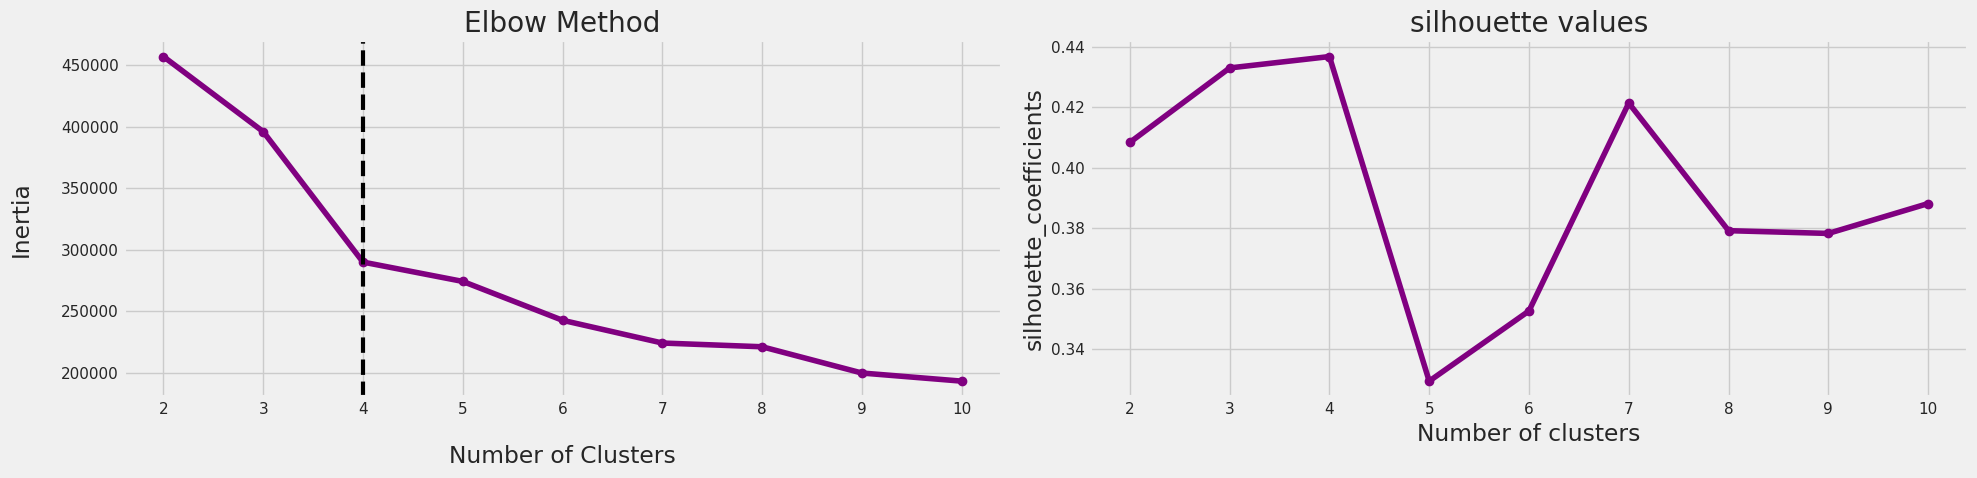

In [55]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(1,2,figsize=(20,5))
kl = KneeLocator(range(2,11), inertias, curve='convex', direction="decreasing")
ax[0].plot(range(2,11), inertias,color='purple',marker='o',label='Elbow Method')
ax[0].set_xticks(range(2,11))
ax[0].set_xlabel("Number of Clusters", labelpad=20)
ax[0].set_ylabel("Inertia", labelpad=20)
ax[0].set_title("Elbow Method")
ax[0].axvline(x=kl.elbow, color='black', label='axvline-fullheight', ls='--', linewidth=3)

ax[1].plot(range(2,11), silhouette_coefficients,color='purple',marker='o',label='silhouette coefficients')
ax[1].set_xticks(range(2,11))
ax[1].set_title("silhouette values")
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("silhouette_coefficients")
plt.tight_layout();

It shows that there are 5 clusters in the dataset

In [56]:
kmeans = KMeans(n_clusters=5 , **kmeans_set)
kmeans.fit(df_scaled)
df_scaled['Label']=kmeans.labels_
df_scaled.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Frequency,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,Recency,Label
0,-0.400541,0.619078,-0.100958,-0.238805,-0.834336,-0.310357,2
1,-0.400541,0.619078,-0.121610,-0.140066,-0.119389,-0.310357,2
2,-0.400541,-1.615306,0.113488,-0.108123,0.595557,-0.310357,1
3,-0.400541,0.619078,-0.096452,-0.211014,-0.357705,-0.310357,2
4,-0.400541,0.619078,-0.129578,-0.223917,-0.119389,-0.310357,2


In [58]:
attributes = df_scaled.columns[:6]
colors=['purple','yellow','red','blue','magenta','orange']
cluster=['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6']

fig = go.Figure()
for index in range(0,6):
    # Calculate mean values for each attribute within the cluster, preserving the array structure
    r_values = df_scaled.loc[df_scaled.Label == index, attributes].mean().values
    fig.add_trace(go.Scatterpolar(
        r=r_values,  # Pass the array of mean values
        theta=attributes,
        fill='toself',
        fillcolor=colors[index],
        opacity=0.4,
        name=cluster[index]
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    showlegend=True,
    title="Radar plot - Cluster attributes (Normalized Values)"
)



- cluster1 : has customers with Frequency and Recency but the other columns are the same

- cluster2 : has customers with high Frequencyt, Recency, CustomerAge, TransactionAmount(INR) and Account Balance but the other columns are the same

- cluster3:

- cluster4: has customer high transcation amount and medium Account Balance but the other columns are the same

- cluster5 : has customers with high CustomerAge but the other columns are the same


